# Object Detection Using Pytorch
In this project I finetune a CNN model for basic object detection. It also includes special techniques to deal with pre processing and data augmentation of an object detection dataset that consists of bounding boxes in the form of pixel coordinates that is meant to be overlayed on top of images containing objects.
<br>
 The input of the network is an image containing object and the output is the max and min pixel coordinate of the predicted bounding box surrounding the object in the image.
 <br>
 The project flows in sequential order and the exectution of each cell gives an idea of the basic techniques and workflow of a typical machine learning application project.


In [ ]:
# Installing requirements and libraries

# libraries for model load
!pip install timm
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

In [ ]:
# Downloading the dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

In [ ]:
# Importing common libraries

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [ ]:
# Adds the newly imported files to the path
import sys
sys.path.append('/content/object-localization-dataset')

In [ ]:
# Making the configurations for the object detector

CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'

NUM_COR = 4

In [ ]:
# Loading the data
df = pd.read_csv(CSV_FILE)

df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


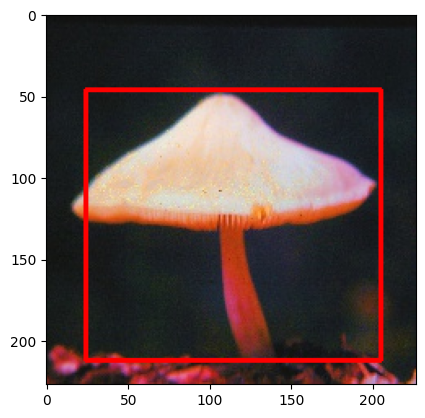

In [ ]:
# Exploring the dataset

row = df.iloc[15] # used to select rows and columns by position/index
img = cv2.imread(DATA_DIR + row.img_path) # appends the image path from the 2 index row
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
b_box = cv2.rectangle(img, pt1, pt2, (255, 0, 0), 2)

plt.imshow(img)

In [ ]:
# Splitting the dataset into train and val
# As the dataset is very small, we don't create any test set and use val as test during inferencing

train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42) # a convenient sklearn function. 20% val, 80% train. 42 captures the pseudo random reproducibility


In [ ]:
# Albumentations is a library for data augmentation for classification, object detection, kp detection etc.
# Augmenting the data for training

# considerations: need to rotate the b box as well for localization task along with images

import albumentations as A

In [ ]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p = 0.5),
    A.Rotate()
], bbox_params = A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE)
], bbox_params = A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

# Creating the custom dataset
As a pair of image and associated bounding box

In [ ]:
class ObjLocDdataset(torch.utils.data.Dataset):
  def __init__(self, df, augmentations= None):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax

    bbox = [[xmin, ymin, xmax, ymax]]

    img_path = DATA_DIR + row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data = self.augmentations(image = img, bboxes = bbox, class_labels = [None])
      img = data['image']
      bbox = data['bboxes'][0]

    # converting to tensor for pytorch
    img  = torch.from_numpy(img).permute(2, 0, 1) / 255.0 # channel axis shifted to 0th axis and image scaled (c, h, w)
    bbox = torch.Tensor(bbox)

    return img, bbox


In [ ]:
trainset = ObjLocDdataset(train_df, train_augs)
validset = ObjLocDdataset(valid_df, valid_augs)

print("Training Examples: {}".format(len(trainset))) # here the magic method __len__() is called on the object
print("Validation Examples: {}".format(len(validset)))

Training Examples: 148
Validation Examples: 38


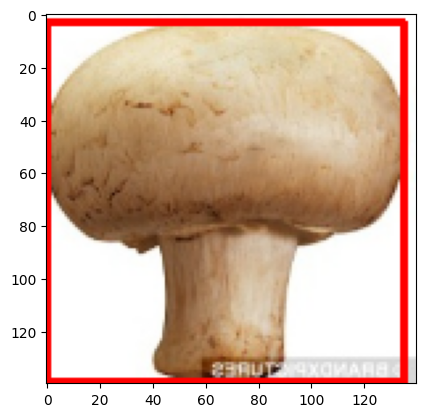

In [ ]:
from albumentations.augmentations.geometric.functional import bbox_affine
# Plotting the newly created dataset

img, bbox = trainset[15]
xmin, ymin, xmax, ymax = bbox
pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bounded_image = cv2.rectangle(img.permute(1,2,0).numpy(), pt1, pt2, (255,0,0), 2)
plt.imshow(bounded_image)

# Creating the dataloader

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = torch.utils.data.DataLoader(validset, batch_size = BATCH_SIZE, shuffle = False)

print("Batches in Training Set: {}".format(len(trainloader)))
print("Batches in Validation Set: {}".format(len(validloader)))

Batches in Training Set: 10
Batches in Validation Set: 3


In [ ]:
# Sanity check to see if everything checks out
for images, bboxes in trainloader:
  break;

print("Shape of the images loaded: {}".format(images.shape))
print("Shape of the boxes: {}".format(bboxes.shape))


Shape of the images loaded: torch.Size([16, 3, 140, 140])
Shape of the boxes: torch.Size([16, 4])


# Loading the pre trained model

In [ ]:
from torch import nn
import timm

In [ ]:
class ObjLocModel(nn.Module):
  def __init__(self):
    # calling base class constructor by using super and __init__() syntax
    super(ObjLocModel, self).__init__()

    # backbone is an inherited attribute from the nn parent class
    self.backbone = timm.create_model(MODEL_NAME, pretrained = True, num_classes = 4)

  def forward(self, images, gt_bboxes = None):
    bboxes = self.backbone(images)

    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes, loss
    return bboxes

model = ObjLocModel()
model.to(DEVICE);

In [ ]:
random_img = torch.rand(1, 3, 140, 140).to(DEVICE)
model(random_img).shape


torch.Size([1, 4])

In [ ]:
# Training and Evaluation Functions

def train_fn(model, dataloader, optimizer):
  total_loss = 0.0
  model.train() # shifting the model to training mode to enable the dropout layers

  for data in tqdm(dataloader):
    images, gt_bboxes = data
    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

    bboxes, loss = model(images, gt_bboxes)

    optimizer.zero_grad() #  used to reset the gradients of the model parameters before computing the gradients for a new batch
    loss.backward() # finds the gradients
    optimizer.step() # updates the weights and biases, aka parameters

    total_loss += loss.item()

  return total_loss / len(dataloader)

def eval_fn(model, dataloader):
  total_loss = 0.0
  model.eval() # shifting the model to eval mode to disable the dropout layers

  with torch.no_grad(): # no gradient computation in eval loop as parameters are not updated
    for data in tqdm(dataloader):
      images, gt_bboxes = data
      images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

      bboxes, loss = model(images, gt_bboxes)
      total_loss += loss.item()

  return total_loss / len(dataloader)


In [ ]:
# Training

optimizer = torch.optim.Adam(model.parameters(), lr = LR)
best_valid_loss = np.Inf # error is maximum to begin with

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("Weights were saved...")
    best_valid_loss = valid_loss

  print(f"Epoch: {i+1} Train loss: {train_loss} Valid loss: {valid_loss}")



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights were saved...
Epoch: 1 Train loss: 5201.6290283203125 Valid loss: 2969.440185546875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 2 Train loss: 1748.6353759765625 Valid loss: 4752.345296223958


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights were saved...
Epoch: 3 Train loss: 1016.998681640625 Valid loss: 741.9546915690104


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights were saved...
Epoch: 4 Train loss: 625.5238891601563 Valid loss: 226.13971964518228


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights were saved...
Epoch: 5 Train loss: 425.6171173095703 Valid loss: 183.17194112141928


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights were saved...
Epoch: 6 Train loss: 334.5553833007813 Valid loss: 156.53713989257812


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 7 Train loss: 212.22940368652343 Valid loss: 177.2730916341146


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights were saved...
Epoch: 8 Train loss: 209.4155044555664 Valid loss: 155.5130360921224


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 9 Train loss: 147.79411087036132 Valid loss: 158.51348368326822


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights were saved...
Epoch: 10 Train loss: 125.0099380493164 Valid loss: 126.84614562988281


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights were saved...
Epoch: 11 Train loss: 108.4862892150879 Valid loss: 122.30941009521484


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights were saved...
Epoch: 12 Train loss: 92.61630172729492 Valid loss: 120.1983133951823


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights were saved...
Epoch: 13 Train loss: 85.61112403869629 Valid loss: 108.72070566813152


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 14 Train loss: 96.86190414428711 Valid loss: 113.55884806315105


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 15 Train loss: 93.43497772216797 Valid loss: 121.57552083333333


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 16 Train loss: 77.34733543395996 Valid loss: 121.84415944417317


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights were saved...
Epoch: 17 Train loss: 85.7936855316162 Valid loss: 87.06318791707356


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights were saved...
Epoch: 18 Train loss: 83.15328979492188 Valid loss: 84.64795684814453


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights were saved...
Epoch: 19 Train loss: 68.78568878173829 Valid loss: 83.76050694783528


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights were saved...
Epoch: 20 Train loss: 69.13905601501465 Valid loss: 72.85293960571289


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 21 Train loss: 63.85543556213379 Valid loss: 87.68280029296875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 22 Train loss: 76.11839408874512 Valid loss: 78.18256505330403


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights were saved...
Epoch: 23 Train loss: 46.92336025238037 Valid loss: 68.63011296590169


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 24 Train loss: 68.20968513488769 Valid loss: 87.68788019816081


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 25 Train loss: 71.0929126739502 Valid loss: 99.96041361490886


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 26 Train loss: 55.83702926635742 Valid loss: 77.80969746907552


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 27 Train loss: 51.09929161071777 Valid loss: 71.22451655069987


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 28 Train loss: 42.33678073883057 Valid loss: 83.23147201538086


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights were saved...
Epoch: 29 Train loss: 52.34981803894043 Valid loss: 54.588297526041664


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 30 Train loss: 48.75176067352295 Valid loss: 74.77902348836263


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 31 Train loss: 34.41506366729736 Valid loss: 58.541768391927086


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 32 Train loss: 55.94126720428467 Valid loss: 64.0603510538737


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 33 Train loss: 38.17160511016846 Valid loss: 62.62870661417643


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 34 Train loss: 53.850739288330075 Valid loss: 62.19732411702474


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 35 Train loss: 40.6780668258667 Valid loss: 74.33355331420898


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 36 Train loss: 48.848836708068845 Valid loss: 60.32942581176758


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights were saved...
Epoch: 37 Train loss: 40.005964279174805 Valid loss: 46.1126823425293


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 38 Train loss: 48.53225936889648 Valid loss: 100.12349446614583


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 39 Train loss: 46.71517143249512 Valid loss: 75.94210688273112


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 40 Train loss: 35.25453052520752 Valid loss: 88.61881256103516


In [ ]:
# Inferencing

# comparing gt bounding boxes with the predicted bounding boxes

import cv2
import numpy
import torch

import matplotlib.pyplot as plt

# Function to plot the gt and prediction on top of each other
def compare_plots(image, gt_bbox, out_bbox):

    xmin, ymin, xmax, ymax = gt_bbox

    pt1 = (int(xmin), int(ymin))
    pt2 = (int(xmax), int(ymax))

    out_xmin, out_ymin, out_xmax, out_ymax = out_bbox[0]

    out_pt1 = (int(out_xmin), int(out_ymin))
    out_pt2 = (int(out_xmax), int(out_ymax))

    out_img = cv2.rectangle(image.squeeze().permute(1, 2, 0).cpu().numpy(),pt1, pt2,(0,255,0),2)
    out_img = cv2.rectangle(out_img,out_pt1, out_pt2,(255,0,0),2)
    plt.imshow(out_img)


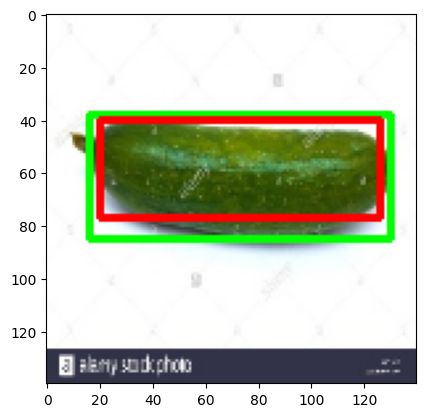

In [ ]:
from timm.models.volo import outlooker_blocks
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
  image, gt_bbox = validset[8] # (c, h, w) that came from the dataset
  image = image.unsqueeze(0).to(DEVICE) # (batch size, c, h, w) adding batch size in zeroth axis
  out_bbox = model(image)

  compare_plots(image, gt_bbox, out_bbox)

In [ ]:
# saving model for future

from google.colab import drive
drive.mount('/content/drive')

!mkdir -p "/content/drive/MyDrive/ObjectDetectionProject"

!cp best_model.pt ./drive/MyDrive/ObjectDetectionProject/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
